In [1]:
import numpy as np
import pandas as pd
import fine_tuning

### Training language and general setup

In [2]:
data_path = "../data/sentiment/"
task = "sentiment"
short_model_name = "xlm-roberta"
experiment = "tfm"
checkpoints_path = "E:/TFM_CCIL/checkpoints/"
use_class_weights = False
        
training_lang = fine_tuning.get_global_training_state(data_path, short_model_name, experiment, checkpoints_path)
trainer = fine_tuning.Trainer(training_lang, data_path, task, short_model_name, use_class_weights)

Training language:   Slovak 

Already trained:     Bulgarian  English

Not yet trained:     Croatian  Chinese  Vietnamese  Thai  Finnish  Basque  Korean  Arabic  Hebrew

Cannot train:      



### Model setup

In [3]:
# Model parameters
max_length = 512
batch_size = 4
learning_rate = 2e-5
epochs = 20

# Model creation
trainer.build_model(max_length, batch_size, learning_rate, epochs, num_labels=2, eval_batch_size=32)

# Checkpoint for best model weights
trainer.setup_checkpoint(checkpoints_path)

Some weights of the model checkpoint at jplu/tf-xlm-roberta-base were not used when initializing TFXLMRobertaForSequenceClassification: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFXLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFXLMRobertaForSequenceClassification were not initialized from the model checkpoint at jplu/tf-xlm-roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successfully built tf-xlm-roberta-base
Checkpoint file: E:/TFM_CCIL/checkpoints/sk/tf-xlm-roberta-base_sentiment_checkpoint_balancedclasses.hdf5
Temp weights file: E:/TFM_CCIL/checkpoints/sk/tf-xlm-roberta-base_temp.hdf5


### Data preparation

In [4]:
limit = 10

trainer.prepare_data(limit=limit)

print("Train examples:", trainer.train_data.shape[0])
if trainer.use_class_weights:
    trainer.calc_class_weights()
    print(trainer.class_weights)

e:\anaconda\envs\tfm_ccil\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel



Train examples: 20


### Training

Elapsed:                 0:16:07                  
Estimated remaining:     0:54:49                  



History:

Best dev score so far: 0.661

Epoch               Loss                Train score         Dev score           
0                   0.711               0.460               0.465               
1                   0.708               0.460               0.465               
2                   0.679               0.460               0.465               
3                   0.611               0.638               0.661               
4                   0.626               0.608               0.582               



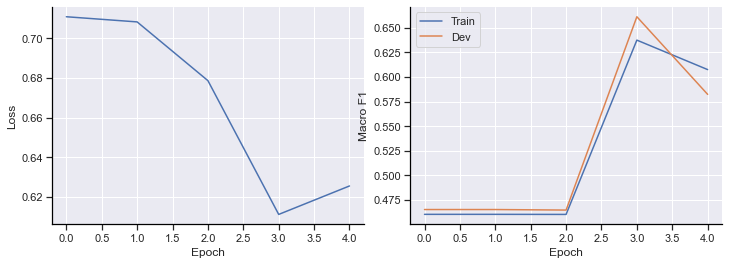


Epoch 5
5/5 [==============================] - 3s 555ms/step - loss: 0.5879
Saving temp weights...
 39/117 [=========>....................] - ETA: 1:41

KeyboardInterrupt: 

In [6]:
trainer.setup_training()
trainer.train()

In [16]:
confirm = input("Confirm weight file overwrite: ")

if confirm == "y":
    print("Overwriting")
    os.replace(checkpoint_dir + model_name + "_sentiment_checkpoint.hdf5", 
               checkpoint_dir + model_name + "_sentiment.hdf5")
    os.replace(checkpoint_dir + "checkpoint_report.xlsx", 
               checkpoint_dir + "last_report.xlsx")
else:
    print("Aborting")

Confirm weight file overwrite: y
Overwriting
